# 2021/10/19
# 本代码比对merra2资料与famil资料之间的差异；选取变量为风向角的转变
# 注意在这个里面计算平均不是采取缺测加值等于缺测、而是跳过缺测值

In [1]:
import xarray as xr
import numpy as np
import os
import math
import sys
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *

np.set_printoptions(suppress=True)

# 计算风向角函数

In [2]:
def cal_jan_angle(u,v):
    u_jan      =  np.average(u[0:31,:],axis=0)
    v_jan      =  np.average(v[0:31,:],axis=0)
    angle_jan  =  u_jan.copy()
    for i in range(0,u_jan.shape[0]):
        for j in range(0,u_jan.shape[1]):
            if (u_jan[i,j]==0 and v_jan[i,j]<0):
                angle_jan[i,j] = 0 ; continue
            elif (u_jan[i,j]==0 and v_jan[i,j]>0):
                angle_jan[i,j] = 180 ; continue
                
            if u_jan[i,j] >0:
                angle_jan[i,j]  =  270 - math.degrees(np.arctan(v_jan[i,j]/u_jan[i,j]))
            else:
                angle_jan[i,j]  =  90  - math.degrees(np.arctan(v_jan[i,j]/u_jan[i,j]))

    return angle_jan

def cal_angle(u,v):
    angle  =  u.copy()
    for i in range(0,u.shape[0]):
        for j in range(0,u.shape[1]):
            if (u[i,j]==0 and v[i,j]<0):
                angle[i,j] = 0 ; continue
            elif (u[i,j]==0 and v[i,j]>0):
                angle[i,j] = 180 ; continue
                
            if u[i,j] >0:
                angle[i,j]  =  270 - math.degrees(np.arctan(v[i,j]/u[i,j]))
            else:
                angle[i,j]  =  90  - math.degrees(np.arctan(v[i,j]/u[i,j]))

    return angle

# 先计算famil的


In [3]:
path  =  "/home/sun/qomo-data/zhuang_plev/"
lat_slice   =   slice(0,30)
lon_slice   =   slice(90,100)

levs  =  [1000,975,950,925,850]
import math
u     =  xr.open_dataset(path+"plev_con_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=875)
v     =  xr.open_dataset(path+"plev_con_V.nc").sel(lat=lat_slice,lon=lon_slice,lev=875)

angle_jan  =  cal_jan_angle(u.U.data,v.V.data)
#这里计算风向角计算全年的吧
angle      =  u.U.data.copy()
for d in range(0,angle.shape[0]):
    angle[d,:]  =  cal_angle(u.U.data[d,:],v.V.data[d,:])
#计算侯平均
angle_pen  =  np.zeros((73,angle.shape[1],angle.shape[2]))
angle_diff =  angle_pen.copy()
for p in range(0,73):
    angle_pen[p,:]  =  np.average(angle[p*5:(p*5+5),:],axis=0)
    angle_diff[p,:] =  angle_pen[p,:] - angle_jan

angle_mask   = angle_diff.copy()
for i in range(0,angle_mask.shape[0]):
    for j in range(0,angle_mask.shape[1]):
        for z in range(0,angle_mask.shape[2]):
            if angle_mask[i,j,z] > 180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]-360)
            if angle_diff[i,j,z] < -180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]+360)
    

angle_diff_avg_lat  =  np.average(angle_diff,axis=2)

# 现在计算MERRA2的风向角转变
## 先计算850hpa的，要是效果凑乎我就不计算925了

In [4]:
path2  =  "/home/sun/qomo-data/year_mean/multi/"
f0     =  xr.open_dataset(path2+"0217.climate.nc").sel(lat=lat_slice,lon=lon_slice,lev=850)

# 声明merra2的daily元数组
u_merra2  =  np.zeros((365,f0.U.data.shape[1],f0.U.data.shape[2]))
v_merra2  =  u_merra2.copy()

# 把数据填充进去
list_merra2  =  os.listdir(path2) ; list_merra2.sort()
for num in range(0,len(list_merra2)):
    file2    =  xr.open_dataset(path2+list_merra2[num]).sel(lat=lat_slice,lon=lon_slice,lev=850)
    u_merra2[num,:]  =  file2.U.data[0,:]
    v_merra2[num,:]  =  file2.V.data[0,:]
    

# 声明merra2的pentad平均元数组
u_merra2_pentad  =  np.zeros((73,file2.U.data.shape[1],file2.U.data.shape[2]))
v_merra2_pentad  =  u_merra2_pentad.copy()

for num in range(0,73):
    u_merra2_pentad[num,:]  =   np.average(u_merra2[num*5:num*5+5,:],axis=0)
    v_merra2_pentad[num,:]  =   np.average(v_merra2[num*5:num*5+5,:],axis=0)



# 计算merra2风向角

In [5]:
angle_jan_merra2  =  cal_jan_angle(u_merra2,v_merra2)
#这里计算风向角计算全年的吧
angle_merra2      =  u_merra2.copy()
for d in range(0,angle.shape[0]):
    angle_merra2[d,:]  =  cal_angle(u_merra2[d,:],v_merra2[d,:])
#计算侯平均
angle_merra2_pen  =  np.zeros((73,angle_merra2.shape[1],angle_merra2.shape[2]))
angle_merra2_diff =  angle_merra2_pen.copy()
for p in range(0,73):
    angle_merra2_pen[p,:]  =  np.average(angle_merra2[p*5:(p*5+5),:],axis=0)
    angle_merra2_diff[p,:] =  angle_merra2_pen[p,:] - angle_jan_merra2

angle_merra2_mask   = angle_merra2_diff.copy()
for i in range(0,angle_merra2_mask.shape[0]):
    for j in range(0,angle_merra2_mask.shape[1]):
        for z in range(0,angle_merra2_mask.shape[2]):
            if angle_merra2_mask[i,j,z] > 180:
                angle_merra2_diff[i,j,z]  =  abs(angle_merra2_diff[i,j,z]-360)
            if angle_merra2_mask[i,j,z] < -180:
                angle_merra2_diff[i,j,z]  =  abs(angle_merra2_diff[i,j,z]+360)
    

angle_merra2_diff_avg_lat  =  np.average(angle_merra2_diff,axis=2)

/tmp/ipykernel_1817557/1316936914.py:11: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(h,orientation='horizontal', pad=0.11, aspect=90,extend='both',extendfrac='auto',)
/tmp/ipykernel_1817557/1316936914.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['EQ',u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N', u'15\N{DEGREE SIGN}N',


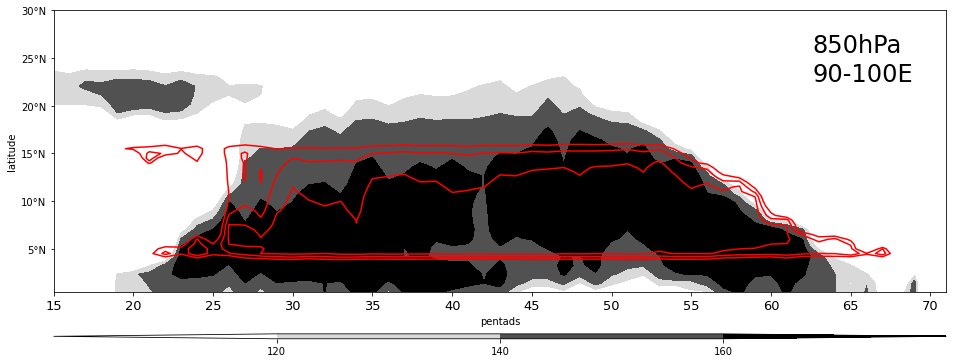

In [6]:
#绘制风向角转变的时间-纬度图
import matplotlib.pyplot as plt
fig1, axes = plt.subplots(figsize = (16,7))
props = dict(boxstyle='square', facecolor='white', edgecolor='white',alpha=1)

levels = np.arange(120, 180,20)
#levels = np.arange(140, 240,20)

h = axes.contourf(np.linspace(1,73,73),u.lat.data,np.transpose(angle_diff_avg_lat,(1,0)), levels = levels,cmap='Greys',extend='both')
axes.contour(np.linspace(1,73,73),f0.lat.data,np.transpose(angle_merra2_diff_avg_lat,(1,0)), levels = levels,colors="red")
cbar = plt.colorbar(h,orientation='horizontal', pad=0.11, aspect=90,extend='both',extendfrac='auto',)


axes.set_xticks(np.linspace(9, 69, 13))
axes.set_xticklabels(range(10, 75, 5),fontsize=13)
axes.set_xlim([14, 70])
axes.set_yticklabels(['EQ',u'5\N{DEGREE SIGN}N', u'10\N{DEGREE SIGN}N', u'15\N{DEGREE SIGN}N',
                        u'20\N{DEGREE SIGN}N',u'25\N{DEGREE SIGN}N',u'30\N{DEGREE SIGN}N'])

axes.text(0.85,0.85,"850hPa",transform=axes.transAxes,bbox=props,fontsize=24)
axes.text(0.85,0.75,"90-100E",transform=axes.transAxes,bbox=props,fontsize=24)
axes.set_xlabel('pentads')
axes.set_ylabel('latitude')

plt.savefig('/home/sun/paint/wind_angle_convert/angle_convert_famil_merra2.pdf', bbox_inches='tight',dpi=1200)
plt.show()

In [7]:
u.lat.data

array([ 0.46875,  1.40625,  2.34375,  3.28125,  4.21875,  5.15625,
        6.09375,  7.03125,  7.96875,  8.90625,  9.84375, 10.78125,
       11.71875, 12.65625, 13.59375, 14.53125, 15.46875, 16.40625,
       17.34375, 18.28125, 19.21875, 20.15625, 21.09375, 22.03125,
       22.96875, 23.90625, 24.84375, 25.78125, 26.71875, 27.65625,
       28.59375, 29.53125])